In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_PLATFORMS"] = "cpu" # only use CPU in this notebook

In [18]:
from functools import partial
from pathlib import Path
from typing import Callable

import blackjax
import click
import jax
import jax.numpy as jnp
from jax import vmap
import jax.scipy as jsp
from jax import jit as jjit
from jax import random
from jax.scipy import stats
from jax.typing import ArrayLike

import matplotlib.pyplot as plt

from bpd import DATA_DIR
from bpd.chains import inference_loop
from bpd.io import load_dataset
from bpd.likelihood import shear_loglikelihood
from bpd.prior import ellip_mag_prior, sample_mag_ellip_prior, sample_ellip_prior, sample_synthetic_sheared_ellips_unclipped

jax.config.update("jax_enable_x64", True)




In [5]:
sigma_m = 1e-5 
sigma_e = 1e-4# need 10^7 bins

In [6]:
key = random.key(43)
samples = sample_mag_ellip_prior(key, sigma=sigma_e, n=1_000_000)

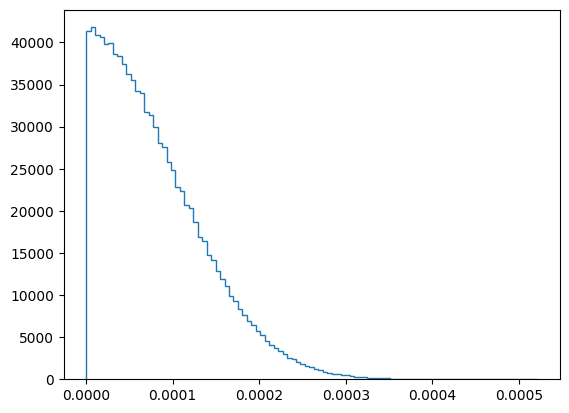

In [7]:
_ = plt.hist(samples, bins=101, histtype='step', )

In [33]:
key = random.key(43)
samples, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(key, (0.02, 0), 
                                                          sigma_m=sigma_m, sigma_e=sigma_e, n=1_000)

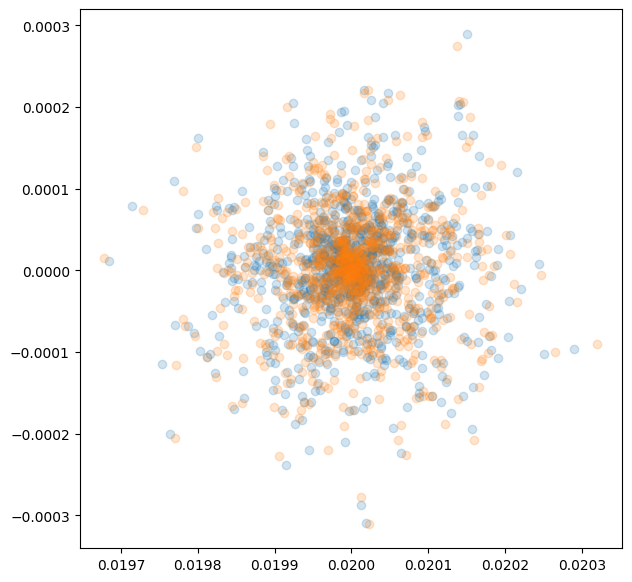

In [34]:
plt.figure(figsize=(7,7))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.2)
plt.scatter(e_sheared[:, 0], e_sheared[:, 1], alpha=0.2)

# Try getting interim posterior samples

In [35]:
def log_target(
    e_sheared: ArrayLike,
    e_obs: ArrayLike,
    sigma_m: float,
    interim_prior: Callable = None,
):
    assert e_sheared.shape == (2,) and e_obs.shape == (2,)

    # ignore angle because flat
    # prior enforces magnitude < 1.0 for posterior samples
    e_sheared_mag = jnp.sqrt(e_sheared[0] ** 2 + e_sheared[1] ** 2)
    prior = jnp.log(interim_prior(e_sheared_mag))

    likelihood = jnp.sum(jsp.stats.norm.logpdf(e_obs, loc=e_sheared, scale=sigma_m))
    return prior + likelihood


def do_inference(
    rng_key,
    init_positions: ArrayLike,
    e_obs: ArrayLike,
    sigma_m: float,
    sigma_e: float,
    k: int,
):
    interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
    _logtarget = partial(
        log_target, e_obs=e_obs, sigma_m=sigma_m, interim_prior=interim_prior
    )

    key1, key2 = random.split(rng_key)

    warmup = blackjax.window_adaptation(
        blackjax.nuts,
        _logtarget,
        progress_bar=False,
        is_mass_matrix_diagonal=True,
        max_num_doublings=3,
        initial_step_size=sigma_e/100,
        target_acceptance_rate=0.80,
    )

    (init_states, tuned_params), _ = warmup.run(key1, init_positions, 1000)
    kernel = blackjax.nuts(_logtarget, **tuned_params).step
    states, _ = inference_loop(key2, init_states, kernel=kernel, n_samples=k)
    return states.position

In [36]:
rng_key = random.key(42)

k1, k2 = random.split(rng_key)

true_g = jnp.array([0.02, 0.0])


e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, true_g, n=1_000, sigma_m=sigma_m, sigma_e=sigma_e
)
e_obs.shape

(1000, 2)

In [37]:
keys2 = random.split(k2, 1_000)
_do_inference_jitted = jjit(
    partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, k=10)
)
_do_inference = vmap(_do_inference_jitted, in_axes=(0, 0, 0))

In [38]:
# compile
_ = _do_inference(keys2[:2], e_sheared[:2], e_obs[:2])

In [39]:
e_post = _do_inference(keys2, e_sheared, e_obs)

In [40]:
e_post.shape

(1000, 10, 2)

In [41]:
e_post[0]

Array([[ 0.01998962, -0.00010675],
       [ 0.01998962, -0.00010675],
       [ 0.01998962, -0.00010675],
       [ 0.01998962, -0.00010675],
       [ 0.01998962, -0.00010675],
       [ 0.01998962, -0.00010675],
       [ 0.01998962, -0.00010675],
       [ 0.01998962, -0.00010675],
       [ 0.01998962, -0.00010675],
       [ 0.01998962, -0.00010675]], dtype=float64)